In [215]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve, convolve1d
from skimage import measure
from sympy import Matrix, symbols
import cv2
from scipy.interpolate import splprep, splev


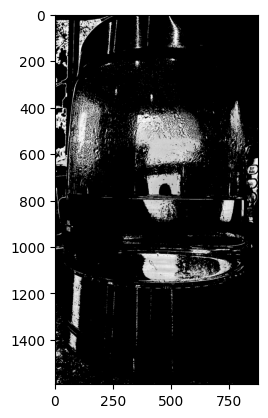

In [216]:
img = cv2.imread('masked_image.png', 0)
plt.imshow(img, cmap='gray')

In [217]:
def show_matrix(image):
    """ Display a formatted matrix of the image """
    m = Matrix(image)
    display(m)

In [218]:
# Create the image to test the edge detection methods on.
# We will use a 10x10 checkered image

checkboard = np.array([[0, 1], 
                       [1, 0]])
checkboard = np.kron(checkboard, np.ones((5,5)))
show_matrix(checkboard)

Matrix([
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

# Gradient-based methods
## Discrete differential operator


In [219]:
# horizontal kernel
Dx = np.array([1, 0, -1], np.float32).reshape((3,1))
# vertical kernel
Dy = np.array([1, 0, -1], np.float32).reshape((1,3))

Display the image after applying a vertical kernel, as well as a horizontal kernel, separately.
Compare how the results differ.

Text(0.5, 1.0, 'Dy')

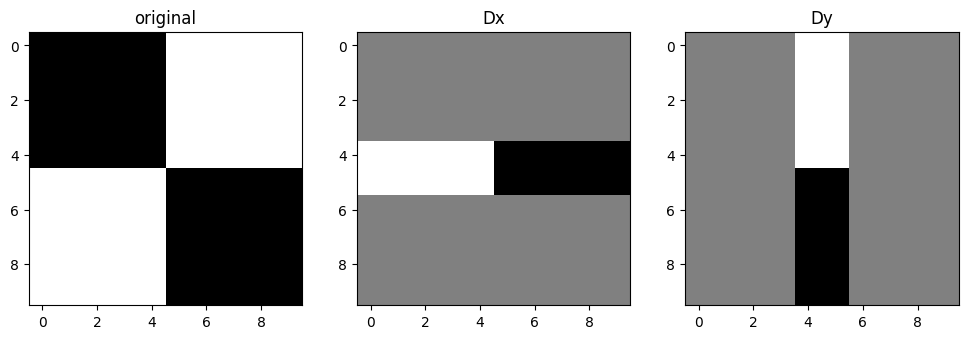

In [220]:
checkboard_x_c = convolve(checkboard, Dx)
checkboard_y_c = convolve(checkboard, Dy)
fig = plt.figure(figsize=(12,12))
fig.add_subplot(1,3,1)
plt.imshow(checkboard, cmap='gray')
plt.title("original")
fig.add_subplot(1,3,2)
plt.imshow(checkboard_x_c, cmap='gray')
plt.title("Dx")
fig.add_subplot(1,3,3)
plt.imshow(checkboard_y_c, cmap='gray')
plt.title("Dy")

Now let's see what happens to the image when we apply a kernel in both vertical and horizontal directions, and then take the magnitude of both, combining into one image.

But first, I'm going to use a higher resolution image, so the effects are more prominent.

In [221]:
# 100 x 100 checkboard instead of 10 x 10
checkboard = np.kron(checkboard, np.ones((5,5)))

In [222]:
def custom_kernel(img, Kx, Ky, alpha=1):
    ''' input: 
            img- a gray scale image
            Kx- kernel for x direction
            Ky- kernel for y direction
            alpha- scaling factor for the kernel
       output: the gray scale edge detection image, and direction matrix theta'''
    # convolution in both directions
    Ix = convolve(img, alpha * Kx)
    Iy = convolve(img, alpha * Ky)

    # calculate the gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    G = G / G.max()
    theta = np.arctan2(Iy, Ix)

    # return combined matrix and angle at which the gradient occurs
    # what is the significance of the angle?
    # answer: the angle indicates the direction of the edge in the image
    # the gradient direction is perpendicular to the edge direction
    # the gradient magnitude indicates the strength of the edge
    # the gradient direction can be used for edge tracking and thinning
    return (G, theta)

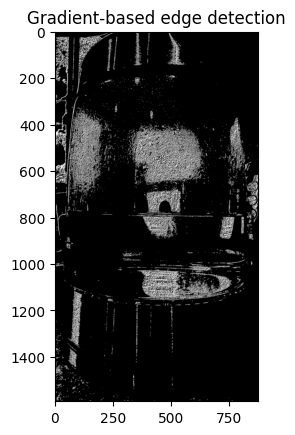

In [223]:
diff_img, theta = custom_kernel(img, Dx, Dy)
plt.title("Gradient-based edge detection")
plt.imshow(diff_img, cmap='gray')

## Gaussian-based edge detection
- We will use a gaussian kernel on our image with two different intensities (sigma), then find the difference

In [224]:
def gaussian_kernel(kernel_size, sigma=1):
    """creates a kernel of size kernel_size. 
    the bigger the kernel size, 
    the more nearby pixels are taken
    into account. bigger kernel size = more blurring"""
    
    size = int(kernel_size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

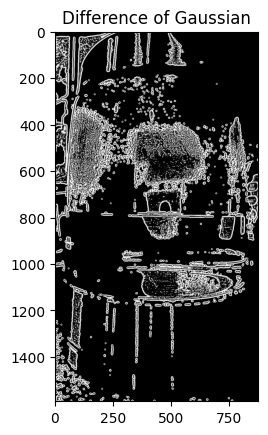

In [225]:
# apply gaussian kernel with sigma 1
checkboard_gauss1 = convolve(img, gaussian_kernel(10, 1))
# apply gaussian kernel with sigma 2
checkboard_gauss2 = convolve(img, gaussian_kernel(10, 2))

# DOG (Difference of Gaussian)
dog = checkboard_gauss1 - checkboard_gauss2
dog_norm = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)

plt.title("Difference of Gaussian")
plt.imshow(dog_norm, cmap='gray')

In [226]:
top5 = sorted(contours, key=lambda x: len(x))
top5 = top5[-5:] 

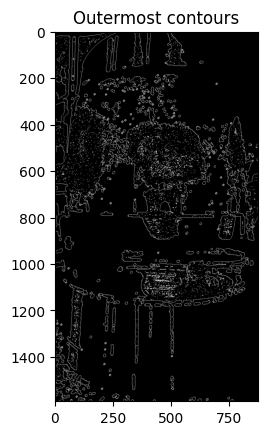

In [229]:
contours = measure.find_contours(dog_norm, 0.5)

# Sort contours by length and keep top 6
top5_contours = sorted(contours, key=lambda x: len(x), reverse=True)#[:6]

# Create a clean outline
outline = np.zeros_like(dog_norm)
for contour in top5_contours:
    for coord in contour:
        outline[int(coord[0]), int(coord[1])] = 1

# Display
plt.title("Outermost contours")
plt.imshow(outline, cmap='gray')

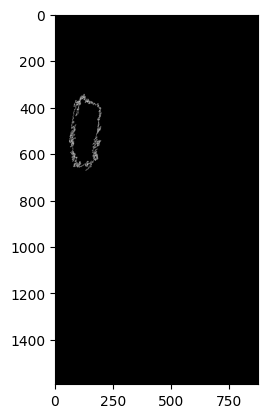

In [228]:
# Find contours
contours = measure.find_contours(diff_img,0.5)

# Keep only the longest contour (assumes cube is the largest object)
longest_contour = max(contours, key=lambda x: len(x))

# Create a clean outline
outline = np.zeros_like(diff_img)
for coord in longest_contour:
    outline[int(coord[0]), int(coord[1])] = 1

plt.imshow(outline, cmap='gray')

In [231]:
step_f = np.array([0, 1, 0])
step_f = np.kron(step_f, np.ones((10)))

In [232]:
step_f

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

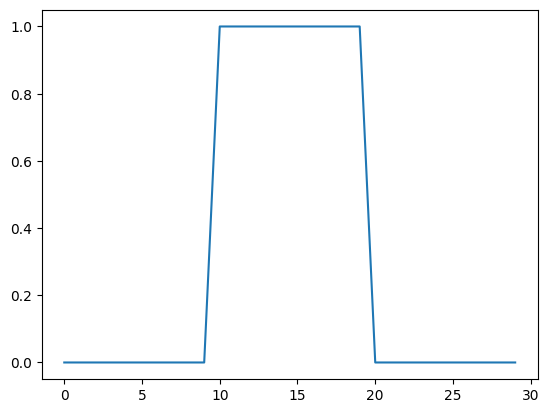

In [233]:
plt.plot(step_f)

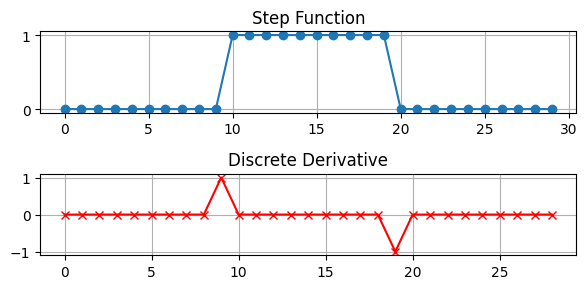

In [236]:
# Define step function
step_f = np.array([0, 1, 0])
step_f = np.kron(step_f, np.ones(10))  # Makes [0 0 0 ... 1 1 1 ... 0 0 0]

# Compute discrete derivative (forward difference)
derivative = np.diff(step_f)

# Plot vertically stacked
plt.figure(figsize=(6, 3))

plt.subplot(2, 1, 1)
plt.title("Step Function")
plt.plot(step_f, marker='o')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Discrete Derivative")
plt.plot(derivative, marker='x', color='r')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
[a1, a2, a3, ...]*[-1,0,1] = [a3-a1, a2-a1, a3-a2, ...]